## Task 1: Maximum Path Length of Association (MPLA)

### A. Generate Graph

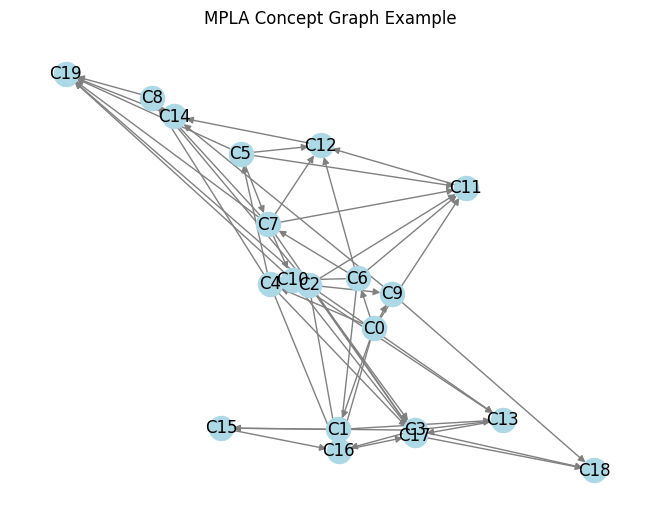

Graph Diameter:  4


In [23]:
import networkx as nx
import matplotlib.pyplot as plt
import random

NUM_CONCEPTS = 20
EDGE_PROB = 0.3 

def compute_diameter(G, use_weakly_connected=True):
    if use_weakly_connected:
        components = nx.weakly_connected_components(G)
    else:
        components = nx.strongly_connected_components(G)

    largest_cc = max(components, key=len)
    subgraph = G.subgraph(largest_cc)

    return nx.diameter(subgraph.to_undirected() if use_weakly_connected else subgraph)


def generate_graph(NUM_CONCEPTS=20, EDGE_PROB=0.3, plot_graph=False):
    """
    Generate a directed graph with a specified number of concepts and edges.
    """
    # Create directed graph
    G = nx.DiGraph()

    # Number of concepts
    NUM_CONCEPTS = 20
    EDGE_PROB = 0.3 
    total_edges = 0

    # Add concepts to graph
    concepts = [f"C{i}" for i in range(NUM_CONCEPTS)]
    G.add_nodes_from(concepts)

    # Add edges (relations) to graph
    for i in range(NUM_CONCEPTS):
        for j in range(i + 1, NUM_CONCEPTS):
            if random.random() < EDGE_PROB:
                G.add_edge(concepts[i], concepts[j])
                total_edges += 1
            
    if plot_graph:
        # Plot graph
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
        plt.title("MPLA Concept Graph Example")
        plt.show()

    return G, total_edges, compute_diameter(G, use_weakly_connected=True)

# Create directed graph
G, total_edges, diameter = generate_graph(NUM_CONCEPTS=NUM_CONCEPTS, EDGE_PROB=EDGE_PROB, plot_graph=True)
concepts = list(G.nodes)
relations = list(G.edges)
print("Graph Diameter: ", diameter)

In [12]:
def get_longest_path(G, source, target):
    # Get all simple (non-cyclic) paths from source to target
    paths = list(nx.all_simple_paths(G, source=source, target=target))
    
    # No valid path
    if not paths:
        return None, 0 
    
    # Sort paths by length and pick the longest
    longest_path = max(paths, key=len)
    return longest_path, len(longest_path) - 1  # length in edges


def is_valid_path(G, path):
    for i in range(len(path) - 1):
        if not G.has_edge(path[i], path[i + 1]):
            return False
    return True

In [40]:
source = f"C{1}"
target = f"C{10}"

path, length = get_longest_path(G, source, target)

if path:
    print(f"Longest path from {source} to {target}: {path}")
    print(f"Path length: {length}")
    print(f"Is this a valid path? {is_valid_path(G, path)}")
else:
    print(f"No valid path from {source} to {target}")

Longest path from C1 to C10: ['C1', 'C2', 'C3', 'C8', 'C10']
Path length: 4
Is this a valid path? True


### B. Generate Data

In [32]:
# Generate simple, directed graph
G, total_edges, diameter = generate_graph(NUM_CONCEPTS, EDGE_PROB, plot_graph=False)

relations = list(G.edges)

# Create concept vocabulary
concepts = [f"<C{i}>" for i in range(NUM_CONCEPTS)]
concept_vocab = {concept: i for i, concept in enumerate(concepts)}

def sample_random_edge(G):
    if G.number_of_edges() == 0:
        return None
    return random.choice(list(G.edges))

def form_creative_association(c1, c2):
    input_text = "".join(["<q>"])
    target_text = input_text + "".join(["<"+c1+">", "<"+c2+">", "</a>"])
    item = {"input_text": input_text, "target_text": target_text}
    return item

def form_creative_association_test():
    input_text = "".join(["<q>"])
    target_text = input_text + "".join(["</a>"])
    item = {"input_text": input_text, "target_text": target_text}
    return item

edge = sample_random_edge(G)
print(form_creative_association(edge[0], edge[1]))
print(form_creative_association_test())

{'input_text': '<q>', 'target_text': '<q><C4><C14></a>'}
{'input_text': '<q>', 'target_text': '<q></a>'}


In [ ]:
import string
import tqdm
import numpy as np

DATA_ROOT = "/Users/samuelschapiro/Desktop/Spiral Works/theory-for-the-emergence-of-creativity-in-llms/graph-paths-novelty/ntp/creativity_data"

NUM_CONCEPTS = 10
EDGE_PROB = 0.3

def generate_mpla_data(num_concepts=NUM_CONCEPTS, edge_prob=EDGE_PROB, num_samples=1000):
    # Generate simple, directed graph
    G, total_edges, diameter = generate_graph(NUM_CONCEPTS, EDGE_PROB, plot_graph=False)

    # Create concept vocabulary
    concepts = [f"<C{i}>" for i in range(NUM_CONCEPTS)]
    concept_vocab = {concept: i for i, concept in enumerate(concepts)}

    train_sequences, test_sequences = [], []
    for _ in range(num_samples):
        edge = sample_random_edge(G)
        if np.random.uniform() > 0.005:
            form_creative_association(edge[0], edge[1])
        else:
            form_creative_association_test()

    return concept_vocab, train_sequences, test_sequences


In [ ]:
import string
import tqdm
import numpy as np

DATA_ROOT = "/Users/samuelschapiro/Desktop/Spiral Works/theory-for-the-emergence-of-creativity-in-llms/graph-paths-novelty/ntp/creativity_data"

# OLD CODE FROM SIBLING DISCOVERY
NUM_A = 10
NUM_B_PER_A = 1000
HASH_STR_LEN = 10

def build_dataset(num_a, num_b_per_a):
    entities_a = ["<a_{}>".format(i) for i in range(num_a)]
    entities_b1 = ["<b1_{}>".format(i) for i in range(num_b_per_a * num_a)]
    entities_b2 = ["<b2_{}>".format(i) for i in range(num_b_per_a * num_a)]
    entity_vocab = entities_a + entities_b1 + entities_b2
    entities_b1_dict = { entity_a: [entities_b1[i * num_b_per_a + j] for j in range(num_b_per_a)] for i, entity_a in enumerate(entities_a) }
    entities_b2_dict = { entity_a: [entities_b2[i * num_b_per_a + j] for j in range(num_b_per_a)] for i, entity_a in enumerate(entities_a) }

    train_sequences, test_sequences = [], []
    for entity_a in tqdm(entities_a):
        entities_b1 = entities_b1_dict[entity_a]
        entities_b2 = entities_b2_dict[entity_a]
        for b1 in tqdm(entities_b1):
            for b2 in entities_b2:
                if np.random.uniform() > 0.005:
                    train_sequences.append(form_creativity(entity_a, b1, b2))
                else:
                    test_sequences.append(form_creativity_test(entity_a, b1, b2))
    
    return entity_vocab, train_sequences, test_sequences, entities_b1_dict, entities_b2_dict

entity_vocab, train_sequences, test_sequences, entities_b1_dict, entities_b2_dict = build_dataset(NUM_A, NUM_B_PER_A, HASH_STR_LEN)